In [1]:

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import timm
import torchsummary
import imageio
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.cuda.amp import GradScaler, autocast

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split, KFold

import sys
sys.path.append('../DataLoader')

from dataloader import SunImageDataset

from torch.func import stack_module_state
from torch.func import vmap

from lightning.fabric import Fabric

In [2]:
torch.set_float32_matmul_precision('medium')
fabric = Fabric(accelerator='cuda', devices=1, precision="bf16-mixed")
fabric.launch()
print(fabric.device)

Using bfloat16 Automatic Mixed Precision (AMP)


cuda:0


In [ ]:
# Hyper-parameters
input_size = 224*224
hidden_size = 166
num_epochs = 20
batch_size = 2
learning_rate = 0.001
dropout = 0.5
# dropout = 0.6990787087509548

In [ ]:
dataset = SunImageDataset(csv_file="D:\\dataset.csv", offset=0, transform=transforms.ToTensor())
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# # Without Validation Set
# trainset, testset = torch.utils.data.Subset(dataset, range(train_size)), torch.utils.data.Subset(dataset, range(train_size, len(dataset)))
# trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=10)

# trainloader = fabric.setup_dataloaders(trainloader)

# With Validation Set
# Split dataset into training and test sets
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, shuffle=False)

# Further split training set into training and validation sets
train_indices, val_indices = train_test_split(train_indices, test_size=0.25, shuffle=False)  # 0.25 x 0.8 = 0.2

trainset = torch.utils.data.Subset(dataset, train_indices)
valset = torch.utils.data.Subset(dataset, val_indices)
testset = torch.utils.data.Subset(dataset, test_indices)

trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(dataset=valset, batch_size=batch_size, shuffle=False)



# # Get a batch of training data
# dataiter = iter(trainloader)
# images, labels = next(dataiter)
# images = torch.stack(images)
# print(images.shape)
# print(labels.shape)

# print(images)
# print(labels)

In [ ]:

class GmiSwinTransformer(nn.Module):
    def __init__(self, hidden_size: int):
        super(GmiSwinTransformer, self).__init__()
        
        # Batch normalization for 3 channels
        self.bn = nn.BatchNorm2d(3)
        
        # Initialize Swin Transformer
        self.pretrained_model = timm.create_model(
            'swin_base_patch4_window7_224',
            pretrained=True,
            num_classes=hidden_size
        )
        
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.LeakyReLU(),
            nn.Linear(hidden_size*10, hidden_size),
            nn.Dropout(p=dropout),  # Added dropout probability
            nn.LeakyReLU(),
            nn.Linear(hidden_size, 1),
            nn.LeakyReLU()
        )
    
    def forward(self, images) -> torch.Tensor:
        """
        Batch should be in format:
        {
            'images': torch.FloatTensor((10, 1, 224, 224))
        }
        """
        
        batch_size = images.shape[0]
        
        images = images.reshape(-1, 1, 224, 224)
        images = torch.cat([images, images, images], dim=1)
        normalized_images = self.bn(images)
        features = self.pretrained_model(normalized_images)
        image_features = features.view(batch_size, -1)
        
        output = self.fc(image_features)
        return output

# Initialize model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = GmiSwinTransformer(hidden_size=hidden_size).to(device)
model = GmiSwinTransformer(hidden_size=hidden_size)

# print(torchsummary.summary(model, (10, 1, 224, 224)))

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model, optimizer = fabric.setup(model, optimizer)
model.train()

_FabricModule(
  (_forward_module): GmiSwinTransformer(
    (bn): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pretrained_model): SwinTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (layers): Sequential(
        (0): SwinTransformerStage(
          (downsample): Identity()
          (blocks): Sequential(
            (0): SwinTransformerBlock(
              (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attn): WindowAttention(
                (qkv): Linear(in_features=128, out_features=384, bias=True)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=128, out_features=128, bias=True)
                (proj_drop): Dropout(p=0.0, inplace=False)
                (softmax): Softmax(dim=-1)
              )
              (drop_pa

In [6]:
torch.cuda.empty_cache()

Training Progress:   0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 1, Index: 0, Loss: 14.7169
Epoch: 1, Index: 1, Loss: 0.5560
Epoch: 1, Index: 2, Loss: 8.1218
Epoch: 1, Index: 3, Loss: 1.7745
Epoch: 1, Index: 4, Loss: 1.3392
Epoch: 1, Index: 5, Loss: 4.3825
Epoch: 1, Index: 6, Loss: 1.7601
Epoch: 1, Index: 7, Loss: 6.3491
Epoch: 1, Index: 8, Loss: 0.5727
Epoch: 1, Index: 9, Loss: 2.4135
Epoch: 1, Index: 10, Loss: 0.1274
Epoch: 1, Index: 11, Loss: 2.8076
Epoch: 1, Index: 12, Loss: 6.1586
Epoch: 1, Index: 13, Loss: 1.7501
Epoch: 1, Index: 14, Loss: 1.5564
Epoch: 1, Index: 15, Loss: 0.6503
Epoch: 1, Index: 16, Loss: 1.3874
Epoch: 1, Index: 17, Loss: 3.6405
Epoch: 1, Index: 18, Loss: 0.1482
Epoch: 1, Index: 19, Loss: 3.5978
Epoch: 1, Index: 20, Loss: 1.8695
Epoch: 1, Index: 21, Loss: 7.7711
Epoch: 1, Index: 22, Loss: 3.5446
Epoch: 1, Index: 23, Loss: 0.4456
Epoch: 1, Index: 24, Loss: 1.4370
Epoch: 1, Index: 25, Loss: 2.0499
Epoch: 1, Index: 26, Loss: 1.0057
Epoch: 1, Index: 27, Loss: 5.6461
Epoch: 1, Index: 28, Loss: 5.6554
Epoch: 1, Index: 29, Lo

Training Progress:   0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 2, Index: 0, Loss: 1.3702
Epoch: 2, Index: 1, Loss: 1.0608
Epoch: 2, Index: 2, Loss: 1.5628
Epoch: 2, Index: 3, Loss: 0.5301
Epoch: 2, Index: 4, Loss: 0.8360
Epoch: 2, Index: 5, Loss: 0.2934
Epoch: 2, Index: 6, Loss: 1.3662
Epoch: 2, Index: 7, Loss: 2.8334
Epoch: 2, Index: 8, Loss: 1.8112
Epoch: 2, Index: 9, Loss: 18.8837
Epoch: 2, Index: 10, Loss: 2.4558
Epoch: 2, Index: 11, Loss: 5.7556
Epoch: 2, Index: 12, Loss: 0.0360
Epoch: 2, Index: 13, Loss: 1.8386
Epoch: 2, Index: 14, Loss: 1.5072
Epoch: 2, Index: 15, Loss: 4.9690
Epoch: 2, Index: 16, Loss: 3.3264
Epoch: 2, Index: 17, Loss: 1.9562
Epoch: 2, Index: 18, Loss: 0.5781
Epoch: 2, Index: 19, Loss: 3.9789
Epoch: 2, Index: 20, Loss: 4.2799
Epoch: 2, Index: 21, Loss: 3.0659
Epoch: 2, Index: 22, Loss: 1.1613
Epoch: 2, Index: 23, Loss: 8.5931
Epoch: 2, Index: 24, Loss: 0.4543
Epoch: 2, Index: 25, Loss: 0.1627
Epoch: 2, Index: 26, Loss: 4.2738
Epoch: 2, Index: 27, Loss: 3.7924
Epoch: 2, Index: 28, Loss: 5.7384
Epoch: 2, Index: 29, Lo

Training Progress:   0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 3, Index: 0, Loss: 0.9707
Epoch: 3, Index: 1, Loss: 2.0259
Epoch: 3, Index: 2, Loss: 2.0327
Epoch: 3, Index: 3, Loss: 1.2208
Epoch: 3, Index: 4, Loss: 1.6115
Epoch: 3, Index: 5, Loss: 1.2056
Epoch: 3, Index: 6, Loss: 1.0026
Epoch: 3, Index: 7, Loss: 0.2998
Epoch: 3, Index: 8, Loss: 1.2013
Epoch: 3, Index: 9, Loss: 0.3754
Epoch: 3, Index: 10, Loss: 4.0846
Epoch: 3, Index: 11, Loss: 2.2815
Epoch: 3, Index: 12, Loss: 3.1079
Epoch: 3, Index: 13, Loss: 3.7588
Epoch: 3, Index: 14, Loss: 1.9057
Epoch: 3, Index: 15, Loss: 4.3893
Epoch: 3, Index: 16, Loss: 3.1478
Epoch: 3, Index: 17, Loss: 1.9405
Epoch: 3, Index: 18, Loss: 4.1772
Epoch: 3, Index: 19, Loss: 1.2151
Epoch: 3, Index: 20, Loss: 4.5946
Epoch: 3, Index: 21, Loss: 2.0171
Epoch: 3, Index: 22, Loss: 1.4949
Epoch: 3, Index: 23, Loss: 7.7120
Epoch: 3, Index: 24, Loss: 3.6524
Epoch: 3, Index: 25, Loss: 0.0291
Epoch: 3, Index: 26, Loss: 0.1058
Epoch: 3, Index: 27, Loss: 1.9414
Epoch: 3, Index: 28, Loss: 0.2209
Epoch: 3, Index: 29, Los

Training Progress:   0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 4, Index: 0, Loss: 2.8838
Epoch: 4, Index: 1, Loss: 3.7780
Epoch: 4, Index: 2, Loss: 1.7586
Epoch: 4, Index: 3, Loss: 0.8103
Epoch: 4, Index: 4, Loss: 0.1251
Epoch: 4, Index: 5, Loss: 1.5100
Epoch: 4, Index: 6, Loss: 2.4424
Epoch: 4, Index: 7, Loss: 6.3883
Epoch: 4, Index: 8, Loss: 1.7701
Epoch: 4, Index: 9, Loss: 2.1457
Epoch: 4, Index: 10, Loss: 1.0173
Epoch: 4, Index: 11, Loss: 0.5548
Epoch: 4, Index: 12, Loss: 2.7623
Epoch: 4, Index: 13, Loss: 1.8197
Epoch: 4, Index: 14, Loss: 11.8280
Epoch: 4, Index: 15, Loss: 0.7392
Epoch: 4, Index: 16, Loss: 3.9947
Epoch: 4, Index: 17, Loss: 1.0293
Epoch: 4, Index: 18, Loss: 0.5185
Epoch: 4, Index: 19, Loss: 0.5372
Epoch: 4, Index: 20, Loss: 1.7230
Epoch: 4, Index: 21, Loss: 2.0194
Epoch: 4, Index: 22, Loss: 2.4742
Epoch: 4, Index: 23, Loss: 3.8532
Epoch: 4, Index: 24, Loss: 2.2944
Epoch: 4, Index: 25, Loss: 0.6723
Epoch: 4, Index: 26, Loss: 0.0368
Epoch: 4, Index: 27, Loss: 1.0914
Epoch: 4, Index: 28, Loss: 0.8192
Epoch: 4, Index: 29, Lo

Training Progress:   0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 5, Index: 0, Loss: 4.5111
Epoch: 5, Index: 1, Loss: 1.4956
Epoch: 5, Index: 2, Loss: 5.7775
Epoch: 5, Index: 3, Loss: 1.3008
Epoch: 5, Index: 4, Loss: 9.1702
Epoch: 5, Index: 5, Loss: 0.5979
Epoch: 5, Index: 6, Loss: 4.7512
Epoch: 5, Index: 7, Loss: 5.7540
Epoch: 5, Index: 8, Loss: 4.9106
Epoch: 5, Index: 9, Loss: 3.0865
Epoch: 5, Index: 10, Loss: 0.2629
Epoch: 5, Index: 11, Loss: 1.7141
Epoch: 5, Index: 12, Loss: 0.5791
Epoch: 5, Index: 13, Loss: 0.9996
Epoch: 5, Index: 14, Loss: 0.4026
Epoch: 5, Index: 15, Loss: 0.2199
Epoch: 5, Index: 16, Loss: 0.5969
Epoch: 5, Index: 17, Loss: 0.8531
Epoch: 5, Index: 18, Loss: 0.5078
Epoch: 5, Index: 19, Loss: 0.4578
Epoch: 5, Index: 20, Loss: 0.4419
Epoch: 5, Index: 21, Loss: 16.8585
Epoch: 5, Index: 22, Loss: 0.4685
Epoch: 5, Index: 23, Loss: 1.6969
Epoch: 5, Index: 24, Loss: 0.2862
Epoch: 5, Index: 25, Loss: 6.7448
Epoch: 5, Index: 26, Loss: 0.8284
Epoch: 5, Index: 27, Loss: 1.8576
Epoch: 5, Index: 28, Loss: 2.2870
Epoch: 5, Index: 29, Lo

Training Progress:   0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 6, Index: 0, Loss: 0.9612
Epoch: 6, Index: 1, Loss: 2.2086
Epoch: 6, Index: 2, Loss: 0.6767
Epoch: 6, Index: 3, Loss: 0.2888
Epoch: 6, Index: 4, Loss: 0.9696
Epoch: 6, Index: 5, Loss: 1.5998
Epoch: 6, Index: 6, Loss: 1.1051
Epoch: 6, Index: 7, Loss: 0.4614
Epoch: 6, Index: 8, Loss: 8.9947
Epoch: 6, Index: 9, Loss: 0.1910
Epoch: 6, Index: 10, Loss: 0.0362
Epoch: 6, Index: 11, Loss: 0.4849
Epoch: 6, Index: 12, Loss: 0.7826
Epoch: 6, Index: 13, Loss: 1.3451
Epoch: 6, Index: 14, Loss: 5.3301
Epoch: 6, Index: 15, Loss: 0.1265
Epoch: 6, Index: 16, Loss: 0.4335
Epoch: 6, Index: 17, Loss: 0.3400
Epoch: 6, Index: 18, Loss: 3.1159
Epoch: 6, Index: 19, Loss: 3.0699
Epoch: 6, Index: 20, Loss: 14.8278
Epoch: 6, Index: 21, Loss: 0.8323
Epoch: 6, Index: 22, Loss: 0.8633
Epoch: 6, Index: 23, Loss: 2.4436
Epoch: 6, Index: 24, Loss: 0.0468
Epoch: 6, Index: 25, Loss: 0.8901
Epoch: 6, Index: 26, Loss: 0.2775
Epoch: 6, Index: 27, Loss: 1.2165
Epoch: 6, Index: 28, Loss: 1.9949
Epoch: 6, Index: 29, Lo

Training Progress:   0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 7, Index: 0, Loss: 0.2931
Epoch: 7, Index: 1, Loss: 0.5687
Epoch: 7, Index: 2, Loss: 0.2644
Epoch: 7, Index: 3, Loss: 0.1275
Epoch: 7, Index: 4, Loss: 3.5363
Epoch: 7, Index: 5, Loss: 0.5730
Epoch: 7, Index: 6, Loss: 1.4539
Epoch: 7, Index: 7, Loss: 0.7522
Epoch: 7, Index: 8, Loss: 1.6645
Epoch: 7, Index: 9, Loss: 0.3230
Epoch: 7, Index: 10, Loss: 2.5837
Epoch: 7, Index: 11, Loss: 0.1275
Epoch: 7, Index: 12, Loss: 0.1477
Epoch: 7, Index: 13, Loss: 1.3330
Epoch: 7, Index: 14, Loss: 1.4183
Epoch: 7, Index: 15, Loss: 0.9862
Epoch: 7, Index: 16, Loss: 18.3862
Epoch: 7, Index: 17, Loss: 2.8555
Epoch: 7, Index: 18, Loss: 2.4848
Epoch: 7, Index: 19, Loss: 1.0456
Epoch: 7, Index: 20, Loss: 0.6743
Epoch: 7, Index: 21, Loss: 1.8225
Epoch: 7, Index: 22, Loss: 1.6541
Epoch: 7, Index: 23, Loss: 0.0319
Epoch: 7, Index: 24, Loss: 7.1026
Epoch: 7, Index: 25, Loss: 1.3024
Epoch: 7, Index: 26, Loss: 1.2142
Epoch: 7, Index: 27, Loss: 1.8045
Epoch: 7, Index: 28, Loss: 0.0524
Epoch: 7, Index: 29, Lo

Training Progress:   0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 8, Index: 0, Loss: 1.9883
Epoch: 8, Index: 1, Loss: 1.7956
Epoch: 8, Index: 2, Loss: 1.8442
Epoch: 8, Index: 3, Loss: 0.5669
Epoch: 8, Index: 4, Loss: 0.0653
Epoch: 8, Index: 5, Loss: 4.7455
Epoch: 8, Index: 6, Loss: 1.2557
Epoch: 8, Index: 7, Loss: 2.6531
Epoch: 8, Index: 8, Loss: 0.3313
Epoch: 8, Index: 9, Loss: 1.1678
Epoch: 8, Index: 10, Loss: 0.6150
Epoch: 8, Index: 11, Loss: 4.6056
Epoch: 8, Index: 12, Loss: 0.5826
Epoch: 8, Index: 13, Loss: 0.4353
Epoch: 8, Index: 14, Loss: 2.3251
Epoch: 8, Index: 15, Loss: 1.7895
Epoch: 8, Index: 16, Loss: 3.7952
Epoch: 8, Index: 17, Loss: 1.7330
Epoch: 8, Index: 18, Loss: 0.2299
Epoch: 8, Index: 19, Loss: 6.5630
Epoch: 8, Index: 20, Loss: 0.9971
Epoch: 8, Index: 21, Loss: 0.1594
Epoch: 8, Index: 22, Loss: 2.3027
Epoch: 8, Index: 23, Loss: 0.6917
Epoch: 8, Index: 24, Loss: 1.4351
Epoch: 8, Index: 25, Loss: 3.3799
Epoch: 8, Index: 26, Loss: 0.0369
Epoch: 8, Index: 27, Loss: 1.3978
Epoch: 8, Index: 28, Loss: 1.3700
Epoch: 8, Index: 29, Los

Training Progress:   0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 9, Index: 0, Loss: 0.4118
Epoch: 9, Index: 1, Loss: 3.7283
Epoch: 9, Index: 2, Loss: 0.1318
Epoch: 9, Index: 3, Loss: 1.1330
Epoch: 9, Index: 4, Loss: 13.0914
Epoch: 9, Index: 5, Loss: 4.4561
Epoch: 9, Index: 6, Loss: 1.1973
Epoch: 9, Index: 7, Loss: 1.7973
Epoch: 9, Index: 8, Loss: 1.7375
Epoch: 9, Index: 9, Loss: 1.8809
Epoch: 9, Index: 10, Loss: 0.4000
Epoch: 9, Index: 11, Loss: 0.1105
Epoch: 9, Index: 12, Loss: 0.4743
Epoch: 9, Index: 13, Loss: 2.2126
Epoch: 9, Index: 14, Loss: 0.0876
Epoch: 9, Index: 15, Loss: 8.0636
Epoch: 9, Index: 16, Loss: 1.2952
Epoch: 9, Index: 17, Loss: 8.7725
Epoch: 9, Index: 18, Loss: 0.8590
Epoch: 9, Index: 19, Loss: 0.0252
Epoch: 9, Index: 20, Loss: 2.9428
Epoch: 9, Index: 21, Loss: 5.0565
Epoch: 9, Index: 22, Loss: 0.4749
Epoch: 9, Index: 23, Loss: 0.3028
Epoch: 9, Index: 24, Loss: 0.5347
Epoch: 9, Index: 25, Loss: 0.1154
Epoch: 9, Index: 26, Loss: 1.9947
Epoch: 9, Index: 27, Loss: 0.3420
Epoch: 9, Index: 28, Loss: 0.3097
Epoch: 9, Index: 29, Lo

Training Progress:   0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 10, Index: 0, Loss: 4.6757
Epoch: 10, Index: 1, Loss: 0.7854
Epoch: 10, Index: 2, Loss: 1.7072
Epoch: 10, Index: 3, Loss: 0.1802
Epoch: 10, Index: 4, Loss: 1.1890
Epoch: 10, Index: 5, Loss: 0.9257
Epoch: 10, Index: 6, Loss: 0.3417
Epoch: 10, Index: 7, Loss: 0.6226
Epoch: 10, Index: 8, Loss: 1.4821
Epoch: 10, Index: 9, Loss: 2.9389
Epoch: 10, Index: 10, Loss: 2.1737
Epoch: 10, Index: 11, Loss: 10.0425
Epoch: 10, Index: 12, Loss: 3.3620
Epoch: 10, Index: 13, Loss: 0.2198
Epoch: 10, Index: 14, Loss: 0.4557
Epoch: 10, Index: 15, Loss: 0.3746
Epoch: 10, Index: 16, Loss: 0.5170
Epoch: 10, Index: 17, Loss: 1.0418
Epoch: 10, Index: 18, Loss: 0.7113
Epoch: 10, Index: 19, Loss: 0.1232
Epoch: 10, Index: 20, Loss: 3.0564
Epoch: 10, Index: 21, Loss: 2.5149
Epoch: 10, Index: 22, Loss: 5.0118
Epoch: 10, Index: 23, Loss: 0.2793
Epoch: 10, Index: 24, Loss: 0.4056
Epoch: 10, Index: 25, Loss: 2.4700
Epoch: 10, Index: 26, Loss: 0.6630
Epoch: 10, Index: 27, Loss: 0.7611
Epoch: 10, Index: 28, Loss: 1

Training Progress:   0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 11, Index: 0, Loss: 2.9826
Epoch: 11, Index: 1, Loss: 1.2314
Epoch: 11, Index: 2, Loss: 0.8461
Epoch: 11, Index: 3, Loss: 4.9877
Epoch: 11, Index: 4, Loss: 3.3497
Epoch: 11, Index: 5, Loss: 0.1599
Epoch: 11, Index: 6, Loss: 0.0597
Epoch: 11, Index: 7, Loss: 1.2629
Epoch: 11, Index: 8, Loss: 1.9927
Epoch: 11, Index: 9, Loss: 2.3265
Epoch: 11, Index: 10, Loss: 4.9495
Epoch: 11, Index: 11, Loss: 0.5086
Epoch: 11, Index: 12, Loss: 2.3764
Epoch: 11, Index: 13, Loss: 2.9746
Epoch: 11, Index: 14, Loss: 0.4560
Epoch: 11, Index: 15, Loss: 0.9288
Epoch: 11, Index: 16, Loss: 16.6098
Epoch: 11, Index: 17, Loss: 1.2834
Epoch: 11, Index: 18, Loss: 3.9123
Epoch: 11, Index: 19, Loss: 2.2543
Epoch: 11, Index: 20, Loss: 1.7032
Epoch: 11, Index: 21, Loss: 0.1631
Epoch: 11, Index: 22, Loss: 0.1988
Epoch: 11, Index: 23, Loss: 5.0561
Epoch: 11, Index: 24, Loss: 0.9583
Epoch: 11, Index: 25, Loss: 2.9252
Epoch: 11, Index: 26, Loss: 2.1485
Epoch: 11, Index: 27, Loss: 0.3227
Epoch: 11, Index: 28, Loss: 0

Training Progress:   0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 12, Index: 0, Loss: 0.4151
Epoch: 12, Index: 1, Loss: 0.3828
Epoch: 12, Index: 2, Loss: 7.2620
Epoch: 12, Index: 3, Loss: 0.2050
Epoch: 12, Index: 4, Loss: 1.4098
Epoch: 12, Index: 5, Loss: 1.1507
Epoch: 12, Index: 6, Loss: 3.1071
Epoch: 12, Index: 7, Loss: 1.7592
Epoch: 12, Index: 8, Loss: 5.4119
Epoch: 12, Index: 9, Loss: 4.0003
Epoch: 12, Index: 10, Loss: 2.6041
Epoch: 12, Index: 11, Loss: 1.6734
Epoch: 12, Index: 12, Loss: 2.7339
Epoch: 12, Index: 13, Loss: 1.8706
Epoch: 12, Index: 14, Loss: 0.9634
Epoch: 12, Index: 15, Loss: 1.5005
Epoch: 12, Index: 16, Loss: 0.1983
Epoch: 12, Index: 17, Loss: 0.6532
Epoch: 12, Index: 18, Loss: 3.3226
Epoch: 12, Index: 19, Loss: 0.4877
Epoch: 12, Index: 20, Loss: 3.5158
Epoch: 12, Index: 21, Loss: 2.0767
Epoch: 12, Index: 22, Loss: 1.4998
Epoch: 12, Index: 23, Loss: 3.5125
Epoch: 12, Index: 24, Loss: 2.9160
Epoch: 12, Index: 25, Loss: 1.7249
Epoch: 12, Index: 26, Loss: 0.1359
Epoch: 12, Index: 27, Loss: 0.1607
Epoch: 12, Index: 28, Loss: 0.

Training Progress:   0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 13, Index: 0, Loss: 0.3447
Epoch: 13, Index: 1, Loss: 1.2141
Epoch: 13, Index: 2, Loss: 0.3350
Epoch: 13, Index: 3, Loss: 3.2197
Epoch: 13, Index: 4, Loss: 2.7721
Epoch: 13, Index: 5, Loss: 0.9472
Epoch: 13, Index: 6, Loss: 0.8737
Epoch: 13, Index: 7, Loss: 7.1491
Epoch: 13, Index: 8, Loss: 1.2316
Epoch: 13, Index: 9, Loss: 4.2843
Epoch: 13, Index: 10, Loss: 2.4862
Epoch: 13, Index: 11, Loss: 0.0940
Epoch: 13, Index: 12, Loss: 0.7986
Epoch: 13, Index: 13, Loss: 0.1764
Epoch: 13, Index: 14, Loss: 0.4775
Epoch: 13, Index: 15, Loss: 0.8600
Epoch: 13, Index: 16, Loss: 1.9107
Epoch: 13, Index: 17, Loss: 0.3772
Epoch: 13, Index: 18, Loss: 1.1250
Epoch: 13, Index: 19, Loss: 2.3695
Epoch: 13, Index: 20, Loss: 0.0094
Epoch: 13, Index: 21, Loss: 1.7571
Epoch: 13, Index: 22, Loss: 0.0413
Epoch: 13, Index: 23, Loss: 1.2294
Epoch: 13, Index: 24, Loss: 0.7840
Epoch: 13, Index: 25, Loss: 1.1558
Epoch: 13, Index: 26, Loss: 1.0456
Epoch: 13, Index: 27, Loss: 2.1665
Epoch: 13, Index: 28, Loss: 0.

Training Progress:   0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 14, Index: 0, Loss: 1.4239
Epoch: 14, Index: 1, Loss: 0.1730
Epoch: 14, Index: 2, Loss: 0.1593
Epoch: 14, Index: 3, Loss: 1.6164
Epoch: 14, Index: 4, Loss: 0.7086
Epoch: 14, Index: 5, Loss: 3.0693
Epoch: 14, Index: 6, Loss: 1.0929
Epoch: 14, Index: 7, Loss: 0.7337
Epoch: 14, Index: 8, Loss: 0.7066
Epoch: 14, Index: 9, Loss: 0.0814
Epoch: 14, Index: 10, Loss: 8.1245
Epoch: 14, Index: 11, Loss: 0.4104
Epoch: 14, Index: 12, Loss: 0.1934
Epoch: 14, Index: 13, Loss: 6.4646
Epoch: 14, Index: 14, Loss: 1.8915
Epoch: 14, Index: 15, Loss: 1.5373
Epoch: 14, Index: 16, Loss: 0.0311
Epoch: 14, Index: 17, Loss: 1.0825
Epoch: 14, Index: 18, Loss: 6.2177
Epoch: 14, Index: 19, Loss: 0.5500
Epoch: 14, Index: 20, Loss: 0.4460
Epoch: 14, Index: 21, Loss: 1.8993
Epoch: 14, Index: 22, Loss: 1.9080
Epoch: 14, Index: 23, Loss: 0.3253
Epoch: 14, Index: 24, Loss: 13.4363
Epoch: 14, Index: 25, Loss: 1.6341
Epoch: 14, Index: 26, Loss: 2.1187
Epoch: 14, Index: 27, Loss: 1.1084
Epoch: 14, Index: 28, Loss: 2

Training Progress:   0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 15, Index: 0, Loss: 3.5834
Epoch: 15, Index: 1, Loss: 0.6838
Epoch: 15, Index: 2, Loss: 1.6715
Epoch: 15, Index: 3, Loss: 0.5114
Epoch: 15, Index: 4, Loss: 0.1496
Epoch: 15, Index: 5, Loss: 0.6035
Epoch: 15, Index: 6, Loss: 0.6776
Epoch: 15, Index: 7, Loss: 0.2783
Epoch: 15, Index: 8, Loss: 1.6193
Epoch: 15, Index: 9, Loss: 1.6200
Epoch: 15, Index: 10, Loss: 0.3077
Epoch: 15, Index: 11, Loss: 1.5971
Epoch: 15, Index: 12, Loss: 0.9070
Epoch: 15, Index: 13, Loss: 2.1373
Epoch: 15, Index: 14, Loss: 1.0404
Epoch: 15, Index: 15, Loss: 0.1257
Epoch: 15, Index: 16, Loss: 5.1144
Epoch: 15, Index: 17, Loss: 19.1741
Epoch: 15, Index: 18, Loss: 1.5292
Epoch: 15, Index: 19, Loss: 0.4089
Epoch: 15, Index: 20, Loss: 1.3477
Epoch: 15, Index: 21, Loss: 0.3750
Epoch: 15, Index: 22, Loss: 1.4933
Epoch: 15, Index: 23, Loss: 2.6482
Epoch: 15, Index: 24, Loss: 0.6020
Epoch: 15, Index: 25, Loss: 0.0712
Epoch: 15, Index: 26, Loss: 0.6926
Epoch: 15, Index: 27, Loss: 2.5446
Epoch: 15, Index: 28, Loss: 2

Training Progress:   0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 16, Index: 0, Loss: 2.1614
Epoch: 16, Index: 1, Loss: 1.6629
Epoch: 16, Index: 2, Loss: 2.3494
Epoch: 16, Index: 3, Loss: 0.4191
Epoch: 16, Index: 4, Loss: 3.3403
Epoch: 16, Index: 5, Loss: 0.5398
Epoch: 16, Index: 6, Loss: 0.9711
Epoch: 16, Index: 7, Loss: 0.8231
Epoch: 16, Index: 8, Loss: 1.1813
Epoch: 16, Index: 9, Loss: 2.8698
Epoch: 16, Index: 10, Loss: 0.8412
Epoch: 16, Index: 11, Loss: 0.9068
Epoch: 16, Index: 12, Loss: 0.2023
Epoch: 16, Index: 13, Loss: 1.3716
Epoch: 16, Index: 14, Loss: 0.1690
Epoch: 16, Index: 15, Loss: 2.1035
Epoch: 16, Index: 16, Loss: 0.5443
Epoch: 16, Index: 17, Loss: 1.0260
Epoch: 16, Index: 18, Loss: 0.9731
Epoch: 16, Index: 19, Loss: 1.0256
Epoch: 16, Index: 20, Loss: 1.0558
Epoch: 16, Index: 21, Loss: 0.2762
Epoch: 16, Index: 22, Loss: 0.6378
Epoch: 16, Index: 23, Loss: 0.0443
Epoch: 16, Index: 24, Loss: 0.1839
Epoch: 16, Index: 25, Loss: 1.8906
Epoch: 16, Index: 26, Loss: 0.4301
Epoch: 16, Index: 27, Loss: 4.5875
Epoch: 16, Index: 28, Loss: 2.

Training Progress:   0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 17, Index: 0, Loss: 1.5146
Epoch: 17, Index: 1, Loss: 1.9974
Epoch: 17, Index: 2, Loss: 1.4342
Epoch: 17, Index: 3, Loss: 7.9539
Epoch: 17, Index: 4, Loss: 0.9285
Epoch: 17, Index: 5, Loss: 0.5699
Epoch: 17, Index: 6, Loss: 2.8952
Epoch: 17, Index: 7, Loss: 0.2028
Epoch: 17, Index: 8, Loss: 0.7931
Epoch: 17, Index: 9, Loss: 0.3612
Epoch: 17, Index: 10, Loss: 1.2070
Epoch: 17, Index: 11, Loss: 1.5510
Epoch: 17, Index: 12, Loss: 1.0000
Epoch: 17, Index: 13, Loss: 0.6076
Epoch: 17, Index: 14, Loss: 0.6488
Epoch: 17, Index: 15, Loss: 5.8940
Epoch: 17, Index: 16, Loss: 0.3596
Epoch: 17, Index: 17, Loss: 5.1305
Epoch: 17, Index: 18, Loss: 0.5348
Epoch: 17, Index: 19, Loss: 0.2022
Epoch: 17, Index: 20, Loss: 2.1239
Epoch: 17, Index: 21, Loss: 3.1880
Epoch: 17, Index: 22, Loss: 0.4643
Epoch: 17, Index: 23, Loss: 3.9341
Epoch: 17, Index: 24, Loss: 0.1731
Epoch: 17, Index: 25, Loss: 3.8434
Epoch: 17, Index: 26, Loss: 1.2137
Epoch: 17, Index: 27, Loss: 4.6533
Epoch: 17, Index: 28, Loss: 0.

Training Progress:   0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 18, Index: 0, Loss: 0.6797
Epoch: 18, Index: 1, Loss: 2.0896
Epoch: 18, Index: 2, Loss: 3.7310
Epoch: 18, Index: 3, Loss: 1.8808
Epoch: 18, Index: 4, Loss: 0.0430
Epoch: 18, Index: 5, Loss: 1.1651
Epoch: 18, Index: 6, Loss: 0.9835
Epoch: 18, Index: 7, Loss: 0.7923
Epoch: 18, Index: 8, Loss: 13.3541
Epoch: 18, Index: 9, Loss: 0.1378
Epoch: 18, Index: 10, Loss: 1.1659
Epoch: 18, Index: 11, Loss: 7.8643
Epoch: 18, Index: 12, Loss: 0.1016
Epoch: 18, Index: 13, Loss: 4.1122
Epoch: 18, Index: 14, Loss: 0.2268
Epoch: 18, Index: 15, Loss: 1.4709
Epoch: 18, Index: 16, Loss: 2.2159
Epoch: 18, Index: 17, Loss: 2.3942
Epoch: 18, Index: 18, Loss: 0.6480
Epoch: 18, Index: 19, Loss: 3.1289
Epoch: 18, Index: 20, Loss: 3.4345
Epoch: 18, Index: 21, Loss: 4.8770
Epoch: 18, Index: 22, Loss: 0.1010
Epoch: 18, Index: 23, Loss: 0.5590
Epoch: 18, Index: 24, Loss: 0.5058
Epoch: 18, Index: 25, Loss: 0.4772
Epoch: 18, Index: 26, Loss: 1.2898
Epoch: 18, Index: 27, Loss: 4.2485
Epoch: 18, Index: 28, Loss: 1

Training Progress:   0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 19, Index: 0, Loss: 0.1253
Epoch: 19, Index: 1, Loss: 2.4292
Epoch: 19, Index: 2, Loss: 0.4882
Epoch: 19, Index: 3, Loss: 1.8733
Epoch: 19, Index: 4, Loss: 2.9731
Epoch: 19, Index: 5, Loss: 1.9196
Epoch: 19, Index: 6, Loss: 0.2610
Epoch: 19, Index: 7, Loss: 0.2305
Epoch: 19, Index: 8, Loss: 1.0173
Epoch: 19, Index: 9, Loss: 2.7639
Epoch: 19, Index: 10, Loss: 1.7408
Epoch: 19, Index: 11, Loss: 0.9262
Epoch: 19, Index: 12, Loss: 0.8871
Epoch: 19, Index: 13, Loss: 0.0588
Epoch: 19, Index: 14, Loss: 0.0159
Epoch: 19, Index: 15, Loss: 11.0656
Epoch: 19, Index: 16, Loss: 1.7936
Epoch: 19, Index: 17, Loss: 3.0719
Epoch: 19, Index: 18, Loss: 0.6325
Epoch: 19, Index: 19, Loss: 1.0029
Epoch: 19, Index: 20, Loss: 0.1587
Epoch: 19, Index: 21, Loss: 2.7090
Epoch: 19, Index: 22, Loss: 0.4114
Epoch: 19, Index: 23, Loss: 0.0561
Epoch: 19, Index: 24, Loss: 1.4673
Epoch: 19, Index: 25, Loss: 1.0045
Epoch: 19, Index: 26, Loss: 0.7169
Epoch: 19, Index: 27, Loss: 0.4346
Epoch: 19, Index: 28, Loss: 7

Training Progress:   0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 20, Index: 0, Loss: 0.2012
Epoch: 20, Index: 1, Loss: 2.0930
Epoch: 20, Index: 2, Loss: 1.9187
Epoch: 20, Index: 3, Loss: 5.7469
Epoch: 20, Index: 4, Loss: 0.1749
Epoch: 20, Index: 5, Loss: 1.3195
Epoch: 20, Index: 6, Loss: 1.9301
Epoch: 20, Index: 7, Loss: 0.7936
Epoch: 20, Index: 8, Loss: 2.5038
Epoch: 20, Index: 9, Loss: 1.7743
Epoch: 20, Index: 10, Loss: 0.4345
Epoch: 20, Index: 11, Loss: 4.5305
Epoch: 20, Index: 12, Loss: 2.4952
Epoch: 20, Index: 13, Loss: 0.6124
Epoch: 20, Index: 14, Loss: 0.4106
Epoch: 20, Index: 15, Loss: 2.5457
Epoch: 20, Index: 16, Loss: 1.5627
Epoch: 20, Index: 17, Loss: 0.8193
Epoch: 20, Index: 18, Loss: 0.4977
Epoch: 20, Index: 19, Loss: 6.3062
Epoch: 20, Index: 20, Loss: 0.7081
Epoch: 20, Index: 21, Loss: 0.4292
Epoch: 20, Index: 22, Loss: 3.6622
Epoch: 20, Index: 23, Loss: 0.2460
Epoch: 20, Index: 24, Loss: 0.0411
Epoch: 20, Index: 25, Loss: 3.2209
Epoch: 20, Index: 26, Loss: 0.5847
Epoch: 20, Index: 27, Loss: 1.4520
Epoch: 20, Index: 28, Loss: 1.

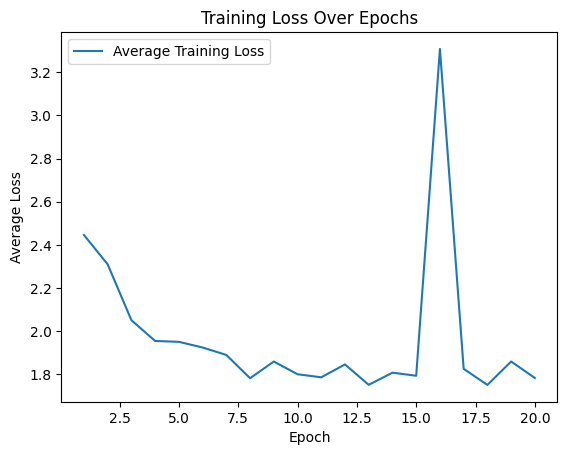

In [7]:
# Training the model
n_total_steps = len(trainloader)
avg_loss_over_epochs = []
for epoch in range(num_epochs):
    train_losses = []
    
    for i, (images, labels) in tqdm(enumerate(trainloader), desc="Training Progress", total=len(trainloader)):
        # Move images and labels to device
        images = torch.stack(images).float()
        images = images.permute(1, 0, 2, 3, 4)  # Change shape to [5, 10, 1, 224, 224]
        labels = labels.float()

        # Forward pass with autograd
        outputs = model(images).squeeze(1)
        loss = criterion(outputs, labels)
        tqdm.write(f"Epoch: {epoch+1}, Index: {i}, Loss: {loss.item():.4f}")

        # Backward pass and optimization
        optimizer.zero_grad()
        fabric.backward(loss)
        optimizer.step()
        # Store the loss
        train_losses.append(loss.item())
    # Store the loss for this epoch
    avg_loss_over_epochs.append(sum(train_losses)/len(train_losses))
# Plot loss over epochs
plt.figure()
plt.plot(range(1, num_epochs + 1), avg_loss_over_epochs, label='Average Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.title('Training Loss Over Epochs')
plt.show()
    

In [ ]:
# Test the model
model.eval()
testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=10)
testloader = fabric.setup_dataloaders(testloader)
test_losses = []

with torch.no_grad():
    for images, labels in tqdm(testloader, desc="Testing Progress"):
        images = torch.stack(images).float()
        images = images.permute(1, 0, 2, 3, 4)
        labels = labels.float()
        outputs = model(images).squeeze(1)
        loss = criterion(outputs, labels)
        test_losses.append(loss.item())
        print("Test loss", test_losses)

avg_test_loss = sum(test_losses) / len(test_losses)
print(f'Average test loss: {avg_test_loss:.4f}')

Testing Progress:   0%|          | 0/103 [00:00<?, ?it/s]

Test loss [0.028133157640695572]
Test loss [0.028133157640695572, 2.6482577323913574]
Test loss [0.028133157640695572, 2.6482577323913574, 0.6742894649505615]
Test loss [0.028133157640695572, 2.6482577323913574, 0.6742894649505615, 1.4357354640960693]
Test loss [0.028133157640695572, 2.6482577323913574, 0.6742894649505615, 1.4357354640960693, 0.47739171981811523]
Test loss [0.028133157640695572, 2.6482577323913574, 0.6742894649505615, 1.4357354640960693, 0.47739171981811523, 1.0593831539154053]
Test loss [0.028133157640695572, 2.6482577323913574, 0.6742894649505615, 1.4357354640960693, 0.47739171981811523, 1.0593831539154053, 0.7801418304443359]
Test loss [0.028133157640695572, 2.6482577323913574, 0.6742894649505615, 1.4357354640960693, 0.47739171981811523, 1.0593831539154053, 0.7801418304443359, 0.6941330432891846]
Test loss [0.028133157640695572, 2.6482577323913574, 0.6742894649505615, 1.4357354640960693, 0.47739171981811523, 1.0593831539154053, 0.7801418304443359, 0.6941330432891846

: 